![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **Regularization in PyTorch - Part 2**
### **Now we use a few Regularization methods on our Fashion-MNIST CNN**

![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/CleanShot%202020-12-02%20at%204.01.54%402x.png)
---



---


In this lesson, we first learn to create a **simple Convolutional Neural Network model** in PyTorch and train it to **classify images in the Fashion-MNIST Dataset**, now **WITH** the use of any regularization methods. 
1. Import PyTorch libraries, define our Transformers, Load our dataset and Visualize our images.
2. Build a Simple CNN with the following **Regularization** methods:
  - L2 Regularization
  - Data Augmentation
  - Dropout
  - BatchNorm
3. Training our CNN with Regularization


# **1. Import PyTorch libraries, Define Transfomers and Load & Visualise Dataset**

In [1]:
import torch
import PIL
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt


print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


In [2]:
device = 'cuda' #'cpu' if no GPU available

# **2. Building a CNN with Regulisation**
## **Implementing Data Augmentation**

#### **Understanding What Our Transforms Do**

1. Our Transforms are applied to an image or batch of images everytime it's loaded.
2. These new images aren't saved, they're generated or 'altered' everytime a batch is loaded

#### **NOTE** 

We don't apply the same augmentations to our Test or Validation Datasets. Therefore, we keep separate transformation functions (see below) for our Train and Validation/Test data.

In [3]:
data_transforms = {
    'train': transforms.Compose([
        # Note these are executed in the order they are called here
        # Some of these transforms return a color image, hence why we need to convert
        # the image back to grayscale
        transforms.RandomAffine(degrees=10, translate=(0.05,0.05), shear=5), 
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15, interpolation=PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, )),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5, ))
    ])
}

### **Fetch and Create our Data Loaders**

In [4]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=data_transforms['train'])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=data_transforms['val'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:02<00:00, 11620668.19it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209799.08it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3878570.07it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19193135.10it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### **Adding Dropout**

In Convolutional Neural Networks Dropout is commonly added after CONV-RELU Layers.

E.g. CONV->RELU->**DROPOUT**

#### **Dropout Recommendations** 

In CNN's values of 0.1 to 0.3 have been found to work well.

### **Adding BatchNorm**

In CNNs **BatchNorm** is best used between the Conv Layer and the activation function layer (ReLU)
When used with Dropout, the recommended order is: 

CONV_1 -> **BatchNorm** -> ReLU -> Dropout - CONV_2

**NOTE** BatchNorm's input arguement is the **output** size of the previous layer.

In [5]:

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 12 * 12, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropOut = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.conv1_bn(self.conv1(x)))
    x = self.dropOut(x)
    x = F.relu(self.conv2_bn(self.conv2(x)))
    x = self.dropOut(x)
    x = self.pool(x)
    x = x.reshape(x.shape[0], -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

### **Adding L2 Regularization**


L2 Regularization on the parameters/weights of the model is directly included in most optimizers, including optim.SGD.

It can be controlled with the **weight_decay** parameter as can be seen in the [SGD documentation](http://pytorch.org/docs/optim.html#torch.optim.SGD).

```weight_decay``` (**float**, optional) – weight decay *(L2 penalty) (default: 0)*

**Good L2 Values range from 0.1 to 0.0001**

**NOTE:**

 L1 regularization is not included by default in the optimizers, but could be added by including an extra loss nn.L1Loss in the weights of the model.



In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# **3. Training Our Model Using Regulisation Methods - Data Augmentation, Dropout, BatchNorm & L2 Regularization**

In [7]:
epochs = 15

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):  
  print(f'Starting Epoch: {epoch+1}...')

  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()

    
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    
    running_loss += loss.item()
    if i % 100 == 99:
      correct = 0 
      total = 0

      with torch.no_grad():
        for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
                    
          outputs = net(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        epoch_num = epoch + 1
        actual_loss = running_loss / 50
        print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
        running_loss = 0.0

  epoch_log.append(epoch_num)
  loss_log.append(actual_loss)
  accuracy_log.append(accuracy)

print('Finished Training')

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.512, Test Accuracy = 70.790%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.601, Test Accuracy = 75.200%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.484, Test Accuracy = 76.880%
Epoch: 1, Mini-Batches Completed: 400, Loss: 1.425, Test Accuracy = 76.500%
Epoch: 1, Mini-Batches Completed: 500, Loss: 1.306, Test Accuracy = 77.290%
Epoch: 1, Mini-Batches Completed: 600, Loss: 1.307, Test Accuracy = 79.130%
Epoch: 1, Mini-Batches Completed: 700, Loss: 1.281, Test Accuracy = 80.030%
Epoch: 1, Mini-Batches Completed: 800, Loss: 1.216, Test Accuracy = 79.950%
Epoch: 1, Mini-Batches Completed: 900, Loss: 1.169, Test Accuracy = 79.520%
Epoch: 1, Mini-Batches Completed: 1000, Loss: 1.249, Test Accuracy = 79.030%
Epoch: 1, Mini-Batches Completed: 1100, Loss: 1.143, Test Accuracy = 81.380%
Epoch: 1, Mini-Batches Completed: 1200, Loss: 1.150, Test Accuracy = 81.390%
Epoch: 1, Mini-Batches Completed: 1300, Loss: 1.131, Test Accura

### **Our Models Accuracy**

In [8]:
correct = 0 
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data

    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 89.34%


### **Training Plots**

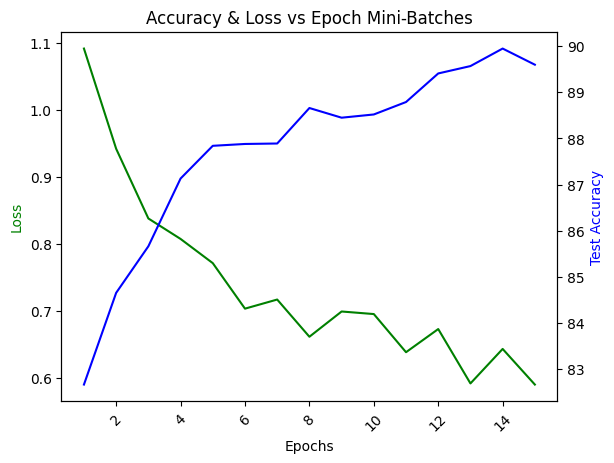

In [9]:
fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

#### **Early Stopping in PyTorch**

https://github.com/Bjarten/early-stopping-pytorch